In [136]:
import gym
import random
import numpy as np   
import matplotlib.pyplot as plt
import collections
import pygame

# Import Tensorflow libraries

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping

from keras.models import load_model


# disable eager execution (optimization)
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# ###### Tensorflow-GPU ########
try:
  physical_devices = tf.config.experimental.list_physical_devices('GPU')
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
  print("GPU found")
except:
  print("No GPU found")


GPU found


## environment


In [166]:
BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
RED = (255, 0, 0)  # Car color
GREEN = (0, 255, 0)  # Goal


class RCMazeEnv(gym.Env):
    def __init__(self, maze_size_x=12, maze_size_y=12):
        self.maze_size_x = maze_size_x
        self.maze_size_y = maze_size_y
        self.maze = self.generate_maze()
        self.car_position = (1, 1)
        self.possible_actions = range(3)
        self.car_orientation = 'E'
        self.sensor_readings = {'front': 0, 'left': 0, 'right': 0}
        self.steps = 0
        self.previous_distance = 0
        self.goal = (10, 10)
        self.visited_positions = set()
        self.reset()

        # Pygame initialization
        pygame.init()
        self.window_width = 600
        self.window_height = 600
        self.screen = pygame.display.set_mode((self.window_width, self.window_height))
        self.cell_width = self.window_width / maze_size_x
        self.cell_height = self.window_height / maze_size_y
        # pygame clock
        self.clock = pygame.time.Clock()
        pygame.display.set_caption("RC Maze Game")

        # Load assets
        self.car_image = self.load_image(
            "../textures/car.png",
            int(self.cell_width),
            int(self.cell_height),
        )

        self.wall_image = self.load_image(
            "../textures/wall_center.png",
            int(self.cell_width),
            int(self.cell_height),
        )

        self.goal_image = self.load_image(
            "../textures/door_closed.png",
            int(self.cell_width),
            int(self.cell_height),
        )
        self.floor_image = self.load_image(
            "../textures/floor_mud_e.png",
            int(self.cell_width),
            int(self.cell_height),
        )
        self.top_of_wall = self.load_image(
            "../textures/gargoyle_top_1.png",
            int(self.cell_width),
            int(self.cell_height),
        )
        self.top_of_wall = pygame.transform.rotate(self.top_of_wall, 180)

    def generate_maze(self):
        # For simplicity, create a static maze with walls
        # '1' represents a wall, and '0' represents an open path
        maze = np.zeros((self.maze_size_y, self.maze_size_x), dtype=int)
        # Add walls to the maze (this can be customized)

        layout = [
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
            [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
            [1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1],
            [1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1],
            [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1],
            [1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1],
            [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        ]

        maze = np.array(layout)

        return maze

    def reset(self):
        self.car_position = (1, 1)
        self.car_orientation = 'E'
        self.update_sensor_readings()
        self.steps = 0
        self.previous_distance = 0
        self.visited_positions.clear()  # Clear the visited positions
        self.visited_positions.add(self.car_position)
        return self.get_state()

    def step(self, action):

        if action == 0:
            self.move_forward()
        elif action == 1:  # Turn left
            self.turn_left()
        elif action == 2:  # Turn right
            self.turn_right()

        self.update_sensor_readings()
        self.visited_positions.add(self.car_position)
        reward = self.compute_reward()
        self.steps += 1
        done = self.is_done()

        return self.get_state(), reward, done

    def move_forward(self):
        x, y = self.car_position

        # Check sensor reading in the direction of car's orientation
        if self.sensor_readings['front'] <= 4:
            # If the sensor reading is 4 or less, do not move forward
            return

        if self.car_orientation == 'N' and y > 0 and self.maze[y - 1][x] != 1:
            self.car_position = (x, y - 1)
        elif self.car_orientation == 'S' and y < self.maze_size_y - 1 and self.maze[y + 1][x] != 1:
            self.car_position = (x, y + 1)
        elif self.car_orientation == 'E' and x < self.maze_size_x - 1 and self.maze[y][x + 1] != 1:
            self.car_position = (x + 1, y)
        elif self.car_orientation == 'W' and x > 0 and self.maze[y][x - 1] != 1:
            self.car_position = (x - 1, y)

    def turn_left(self):
        orientations = ['N', 'W', 'S', 'E']
        idx = orientations.index(self.car_orientation)
        self.car_orientation = orientations[(idx + 1) % 4]

    def turn_right(self):
        orientations = ['N', 'E', 'S', 'W']
        idx = orientations.index(self.car_orientation)
        self.car_orientation = orientations[(idx + 1) % 4]

    def update_sensor_readings(self):
        # Simple sensor implementation: counts steps to the nearest wall
        self.sensor_readings['front'] = self.distance_to_wall('front')
        self.sensor_readings['left'] = self.distance_to_wall('left')
        self.sensor_readings['right'] = self.distance_to_wall('right')

    def distance_to_wall(self, direction):
        x, y = self.car_position
        sensor_max_range = 255  # Maximum range of the ultrasonic sensor

        def calculate_distance(dx, dy):
            distance = 0
            while 0 <= x + distance * dx < self.maze_size_x and \
                0 <= y + distance * dy < self.maze_size_y and \
                self.maze[y + distance * dy][x + distance * dx] != 1:
                distance += 1
                if distance > sensor_max_range:  # Limiting the sensor range
                    break
            return distance

        if direction == 'front':
            if self.car_orientation == 'N':
                distance = calculate_distance(0, -1)
            elif self.car_orientation == 'S':
                distance = calculate_distance(0, 1)
            elif self.car_orientation == 'E':
                distance = calculate_distance(1, 0)
            elif self.car_orientation == 'W':
                distance = calculate_distance(-1, 0)

        elif direction == 'left':
            if self.car_orientation == 'N':
                distance = calculate_distance(-1, 0)
            elif self.car_orientation == 'S':
                distance = calculate_distance(1, 0)
            elif self.car_orientation == 'E':
                distance = calculate_distance(0, -1)
            elif self.car_orientation == 'W':
                distance = calculate_distance(0, 1)

        elif direction == 'right':
            if self.car_orientation == 'N':
                distance = calculate_distance(1, 0)
            elif self.car_orientation == 'S':
                distance = calculate_distance(-1, 0)
            elif self.car_orientation == 'E':
                distance = calculate_distance(0, 1)
            elif self.car_orientation == 'W':
                distance = calculate_distance(0, -1)

        # Normalize the distance to a range of 0-1
        normalized_distance = distance / sensor_max_range
        normalized_distance = max(0, min(normalized_distance, 1))

        return normalized_distance * 1000

    def compute_reward(self):
        """
        Compute the reward based on the current state of the environment


        @return The reward to be added to the step function
        """
        # Initialize reward
        reward = 0

        # Check for collision or out of bounds
        # If the sensor is on the front left right or front side of the sensor is not on the board.
        if any(
            self.sensor_readings[direction] == 0
            for direction in ["front", "left", "right"]
        ):
            reward -= 20

        # Check if goal is reached
        # The reward of the goal.
        if self.car_position == self.goal:
            reward += 500
            # Additional penalty if it takes too many steps to reach the goal
            # If the reward is less than 1000 steps then the reward is decremented by 200.
            if self.steps > 1000:
                reward -= 200
            return reward  # Return immediately as this is the terminal state

        # Calculate the Euclidean distance to the goal
        distance_to_goal = (
            (self.car_position[0] - self.goal[0]) ** 2
            + (self.car_position[1] - self.goal[1]) ** 2
        ) ** 0.5

        # Define a maximum reward when the car is at the goal
        max_reward_at_goal = 50

        # Reward based on proximity to the goal
        reward += max_reward_at_goal / (
            distance_to_goal + 1
        )  # Adding 1 to avoid division by zero

        # # Reward or penalize based on movement towards or away from the goal
        # Move the reward to the goal
        if distance_to_goal < self.previous_distance:
            reward += 50  # Positive reward for moving closer to the goal
        elif distance_to_goal > self.previous_distance:
            reward -= 25  # Negative reward for moving farther from the goal

        # Apply a penalty to revisit the same position
        if self.car_position in self.visited_positions:
            # Apply a penalty for revisiting the same position
            reward -= 10

        # Penalize for each step taken to encourage efficiency
        reward -= 2

        # Update the previous_distance for the next step
        self.previous_distance = distance_to_goal
        return reward

    def is_done(self):
        # is done if it reaches the goal or goes out of bounds or takes more than 3000 steps
        return self.car_position == self.goal or self.steps > 3000 or self.car_position[0] < 0 or self.car_position[1] < 0 or self.car_position[0] > 11 or self.car_position[1] > 11

    def get_state(self):
        car_position = [float(coord) for coord in self.car_position]
        sensor_readings = [float(value) for value in self.sensor_readings.values()]

        state = car_position + [self.car_orientation] + sensor_readings

        # cast state to this ['1.0' '1.0' 'N' '1.0' '1.0' '10.0']
        state = np.array(state, dtype=str)

        # get the orientation and convert do label encoding
        if state[2] == 'N':
            state[2] = 0
        elif state[2] == 'E':
            state[2] = 1
        elif state[2] == 'S':
            state[2] = 2
        elif state[2] == 'W':
            state[2] = 3

        state = np.array(state, dtype=float)

        return state

    def load_image(self, image_path, width, height):
        image = pygame.image.load(image_path)
        image = pygame.transform.scale(image, (width, height))
        return image

    def draw_maze(self):
        for y in range(self.maze_size_y):
            for x in range(self.maze_size_x):
                if self.maze[y][x] == 1:
                    self.screen.blit(
                        self.wall_image, (x * self.cell_width, y * self.cell_height)
                    )

                    self.screen.blit(
                        self.top_of_wall, (x * self.cell_width, y * self.cell_height)
                    )
                    # add top of wall
                if self.maze[y][x] == 0:
                    self.screen.blit(
                        self.floor_image, (x * self.cell_width, y * self.cell_height)
                    )

    def draw_car(self):
        if self.car_orientation == "N":
            car_image = pygame.transform.rotate(self.car_image, 180)
        elif self.car_orientation == "E":
            car_image = pygame.transform.rotate(self.car_image, 90)
        elif self.car_orientation == "S":
            car_image = self.car_image
        elif self.car_orientation == "W":
            car_image = pygame.transform.rotate(self.car_image, 270)

        self.screen.blit(
            car_image,
            (
                self.car_position[0] * self.cell_width,
                self.car_position[1] * self.cell_height,
            ),
        )

    def draw_goal(self):
        self.screen.blit(
            self.goal_image,
            (self.goal[0] * self.cell_width, self.goal[1] * self.cell_height),
        )

    def render(self,render_mode='human', framerate=60, delay=0):
        if render_mode == 'human':
            self.draw_maze()
            self.draw_car()
            self.draw_goal()
            pygame.display.flip()
            self.clock.tick(framerate)  
        elif render_mode == 'rgb_array':
            rendered_maze = np.array(self.maze, dtype=str)
            x, y = self.car_position
            rendered_maze[y][x] = 'C'
            # print array
            print(rendered_maze, '\n')

    def close_pygame(self):
        # Close the Pygame window
        pygame.quit()

# DDQN

In [138]:
mse = tf.keras.losses.MeanSquaredError()
class DQNAgent:
    def __init__(self, replayCapacity, input_shape, output_shape, learning_rate=0.001, discount_factor=0.90):
        self.capacity = replayCapacity
        self.memory = collections.deque(maxlen=self.capacity)
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.policy_model = self.buildNetwork()
        self.target_model = self.buildNetwork()
        self.target_model.set_weights(self.policy_model.get_weights())

    def addToReplayMemory(self, step):
        self.step = step
        self.memory.append(self.step)

    def sampleFromReplayMemory(self, batchSize):
        self.batchSize = batchSize
        if self.batchSize > len(self.memory):
            self.populated = False
            return self.populated
        else:
            return random.sample(self.memory, self.batchSize)

    def buildNetwork(self):
        """
        Builds and compiles the neural network. This is a helper to allow subclasses to override the build method in order to add more features such as learning rate and loss.


        @return A Sequential object that can be used to train the
        """
        model = Sequential(
            [
                Input(shape=self.input_shape),
                Dense(32, activation="relu"),
                Dense(64, activation="relu"),
                Dense(32, activation="relu"),
                Dense(self.output_shape, activation="linear"),
            ]
        )
        model.compile(
            loss=mse,
            optimizer=Adam(learning_rate=self.learning_rate),
            metrics=["mean_squared_error"],  # Use the string identifier
        )
        return model

    def policy_network_fit(self, batch, batch_size):
        states, actions, rewards, next_states, dones = zip(*batch)

        states = np.array(states)
        next_states = np.array(next_states)

        # Predict Q-values for starting state using the policy network
        q_values = self.policy_model.predict(states)

        # Predict Q-values for next state using the policy network
        q_values_next_state_policy = self.policy_model.predict(next_states)

        # Select the best action for the next state using the policy network
        best_actions = np.argmax(q_values_next_state_policy, axis=1)

        # Predict Q-values for next state using the target network
        q_values_next_state_target = self.target_model.predict(next_states)

        # Update Q-values for actions taken
        for i in range(batch_size):
            if dones[i]:
                q_values[i, actions[i]] = rewards[i]
            else:
                # Double DQN update rule
                q_values[i, actions[i]] = rewards[i] + self.discount_factor * q_values_next_state_target[i, best_actions[i]]

        # Train the policy network
        History = self.policy_model.fit(states, q_values, batch_size=batch_size, verbose=0)
        return History

    def policy_network_predict(self, state):
        self.state = state
        self.qPolicy = self.policy_model.predict(self.state)
        return self.qPolicy

    def target_network_predict(self, state):
        self.state = state
        self.qTarget = self.target_model.predict(self.state)
        return self.qTarget

    def update_target_network(self):
        self.target_model.set_weights(self.policy_model.get_weights())

## training

In [139]:
env = RCMazeEnv()
state = env.reset()

env.init_pygame()

# Model parameters
REPLAY_MEMORY_CAPACITY = 2000000
# MIN_REPLAY_MEMORY_SIZE = 1_000  # Minimum number of steps in a memory to start training
POSSIBLE_ACTIONS = env.possible_actions

# state = state[0]
# create DQN agent
agent = DQNAgent(replayCapacity=REPLAY_MEMORY_CAPACITY, 
                input_shape=state.shape, 
                output_shape=len(POSSIBLE_ACTIONS),
                learning_rate=0.001, 
                discount_factor=0.90)

# reset the parameters
DISCOUNT = 0.90
BATCH_SIZE = 128  # How many steps (samples) to use for training
UPDATE_TARGET_INTERVAL = 2
EPSILON = 0.99 # Exploration percentage
MIN_EPSILON = 0.01
DECAY = 0.99973
EPISODE_AMOUNT = 170

# Fill the replay memory with the first batch of samples
update_counter = 0
reward_history = []
epsilon_history = []
loss_history = []
epsilon_history = []
mse_history = []

# step history for each episode
episode_path_history = []
step_history = []

np.set_printoptions(precision=3, suppress=True)

for episode in range(EPISODE_AMOUNT):
    episode_reward = 0
    step_counter = 0  # count the number of successful steps within the episode

    state = env.reset()
    done = False
    epsilon_history.append(EPSILON)

    while not done:
        env.render(delay=0, framerate=720)

        if random.random() <= EPSILON:
            action = random.sample(POSSIBLE_ACTIONS, 1)[0]
        else:
            qValues = agent.policy_network_predict(state.reshape(1,-1))
            action = np.argmax(qValues[0])

        new_state, reward, done = env.step(action)

        step_counter +=1

        # store step in replay memory
        step = (state, action, reward, new_state, done)
        agent.addToReplayMemory(step)
        # add the current car position to the episode path history with the episode number
        episode_path_history.append((episode, env.car_position))
        
        state = new_state
        episode_reward += reward
        # When enough steps in replay memory -> train policy network
        if len(agent.memory) >= (BATCH_SIZE):
            EPSILON = DECAY * EPSILON
            if EPSILON < MIN_EPSILON:
                EPSILON = MIN_EPSILON
            # sample minibatch from replay memory

            miniBatch = agent.sampleFromReplayMemory(BATCH_SIZE)
            miniBatch_states = np.asarray(list(zip(*miniBatch))[0],dtype=float)
            miniBatch_actions = np.asarray(list(zip(*miniBatch))[1], dtype = int)
            miniBatch_rewards = np.asarray(list(zip(*miniBatch))[2], dtype = float)
            miniBatch_next_state = np.asarray(list(zip(*miniBatch))[3],dtype=float)
            miniBatch_done = np.asarray(list(zip(*miniBatch))[4],dtype=bool)

            # current state q values1tch_states)
            y = agent.policy_network_predict(miniBatch_states)

            next_state_q_values = agent.target_network_predict(miniBatch_next_state)
            max_q_next_state = np.max(next_state_q_values,axis=1)

            for i in range(BATCH_SIZE):
                if miniBatch_done[i]:
                    y[i,miniBatch_actions[i]] = miniBatch_rewards[i]
                else:
                    y[i,miniBatch_actions[i]] = miniBatch_rewards[i] + DISCOUNT *  max_q_next_state[i]

            # fit model
            history = agent.policy_network_fit(miniBatch, BATCH_SIZE)

            loss_history.append(history.history['loss'])
            mse_history.append(history.history["mean_squared_error"])

        else:
            continue
        if update_counter == UPDATE_TARGET_INTERVAL:
            agent.update_target_network()
            update_counter = 0
        update_counter += 1
    print('episodeReward for episode ', episode, '= ', episode_reward, 'with epsilon = ', EPSILON)
    step_history.append(step_counter)
    reward_history.append(episode_reward)


env.close_pygame()
env.close()

2024-04-09 17:23:19.657195: W tensorflow/c/c_api.cc:305] Operation '{name:'count_46/Assign' id:11277 op device:{requested: '', assigned: ''} def:{{{node count_46/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_46, count_46/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/lucas/.local/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-04-09 17:23:19.908966: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_139/BiasAdd' id:11267 op device:{requested: '', assigned: ''} def:{{{node dense_139/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_

episodeReward for episode  0 =  -5769.050116616347 with epsilon =  0.5187944229988255
episodeReward for episode  1 =  -1947.446480245088 with epsilon =  0.4244824301378765
episodeReward for episode  2 =  1062.5713434213656 with epsilon =  0.4150743203819337
episodeReward for episode  3 =  1078.5429399294926 with epsilon =  0.40609399048761524
episodeReward for episode  4 =  152.13101762190135 with epsilon =  0.27511579069237524
episodeReward for episode  5 =  1255.3131759513471 with epsilon =  0.2713529051744015
episodeReward for episode  6 =  1055.0133189552262 with epsilon =  0.2660561949011081
episodeReward for episode  7 =  1007.5711750551194 with epsilon =  0.2587581367521975
episodeReward for episode  8 =  1086.7670154862026 with epsilon =  0.25377579125327815
episodeReward for episode  9 =  1199.6573087651345 with epsilon =  0.2506429680844646
episodeReward for episode  10 =  1141.6021056360478 with epsilon =  0.24688124882434787
episodeReward for episode  11 =  1174.16612146976

In [140]:
env.close_pygame()

## results

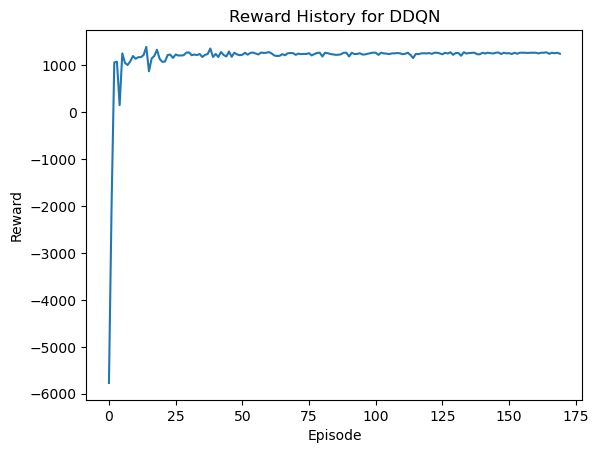

In [180]:
# plot the reward history
plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title("Reward History for DDQN")
plt.show()

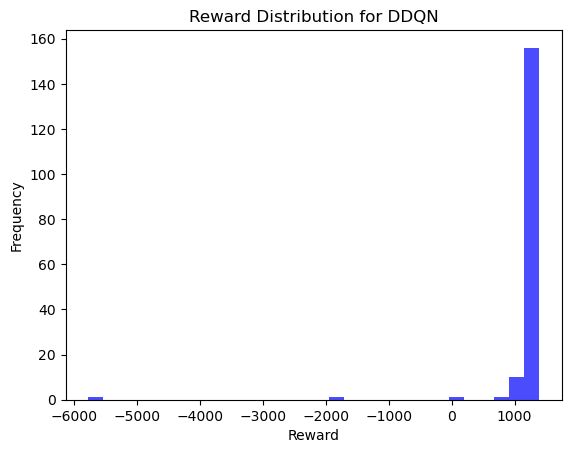

In [179]:
def plot_reward_distribution(rewards, title="Reward Distribution"):
    plt.hist(rewards, bins=30, alpha=0.7, color="blue")
    plt.xlabel("Reward")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.show()


# Example usage:
# Assuming `rewards` is a list of total rewards per episode.
# plot_reward_distribution(rewards)
plot_reward_distribution(reward_history, title="Reward Distribution for DDQN")

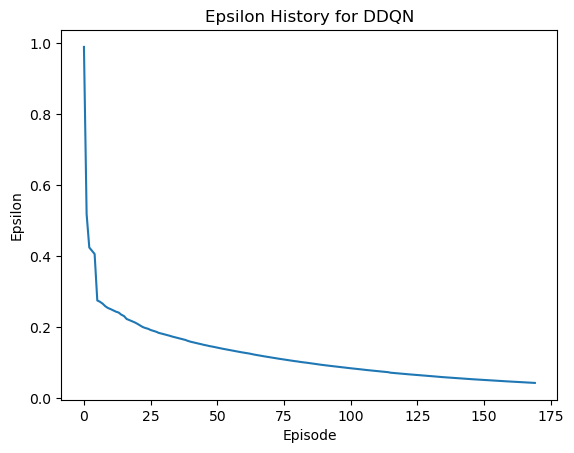

In [178]:
# plot epsilon over time
plt.plot(epsilon_history)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title("Epsilon History for DDQN")
plt.show()

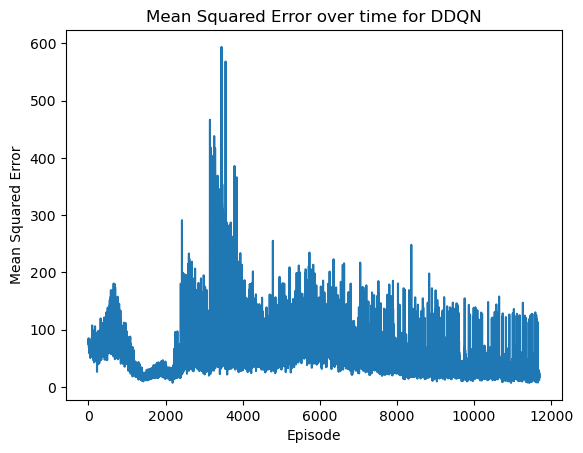

In [177]:
# evalution

# plot mse
plt.plot(mse_history)
plt.xlabel('Episode')
plt.ylabel('Mean Squared Error')
plt.title("Mean Squared Error over time for DDQN")
plt.show()

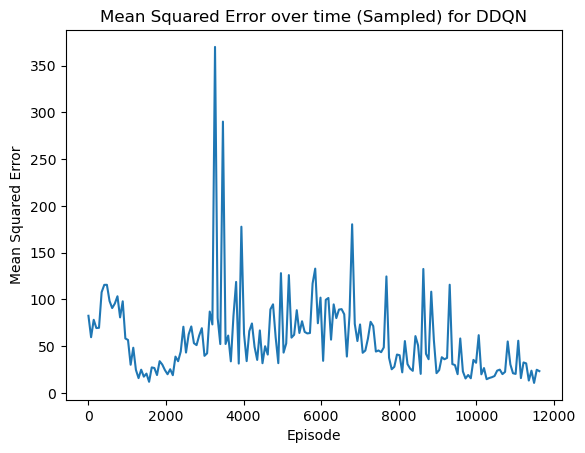

In [176]:
# Assuming mse_history is a flat list with the correct number of elements
EPISODE_AMOUNT = len(mse_history)  # Make sure this reflects the actual number of episodes
desired_samples = 170  # The number of points you want to plot

# Calculate the step size
step = max(EPISODE_AMOUNT // desired_samples, 1)  # Avoid division by zero
sampled_mse_history = mse_history[::step]

# Ensure sampled_episodes has the same number of elements as sampled_mse_history
sampled_episodes = list(range(0, EPISODE_AMOUNT, step))[:len(sampled_mse_history)]

plt.plot(sampled_episodes, sampled_mse_history)
plt.xlabel('Episode')
plt.ylabel('Mean Squared Error')
plt.title("Mean Squared Error over time (Sampled) for DDQN")
plt.show()

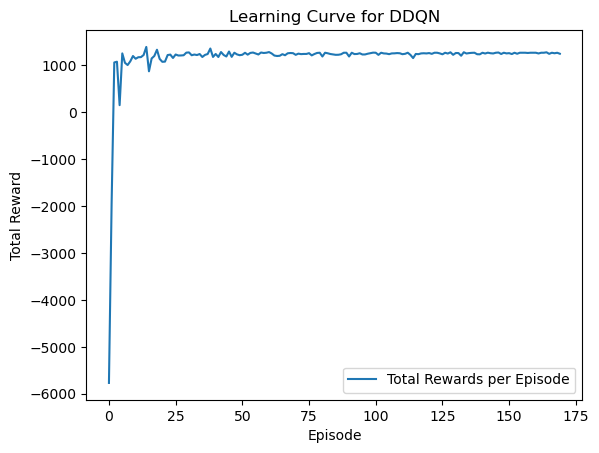

In [175]:
import matplotlib.pyplot as plt

episodes = list(
    range(len(reward_history))
)  # Assuming total_rewards contains the total reward per episode
plt.plot(episodes, reward_history, label="Total Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Learning Curve for DDQN")
plt.legend()
plt.show()

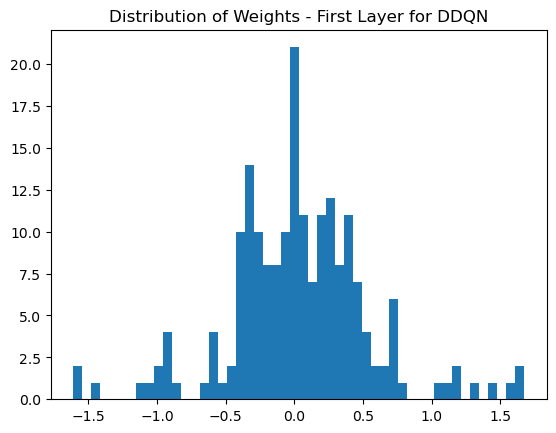

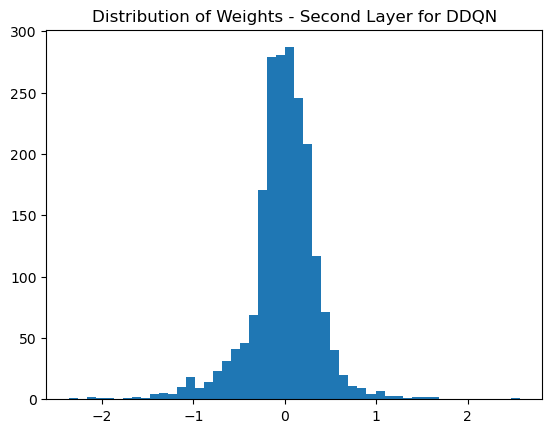

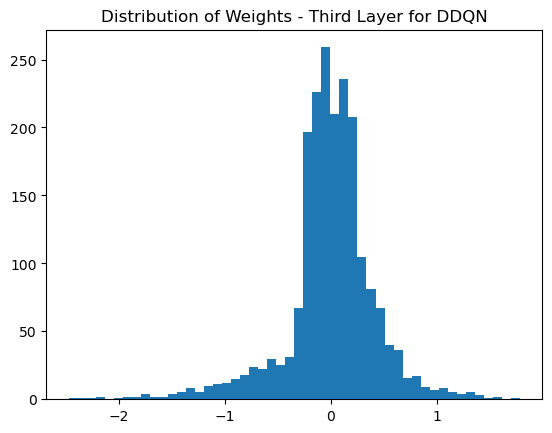

In [174]:
weights, biases = agent.policy_model.layers[0].get_weights()
plt.hist(weights.reshape(-1), bins=50)
plt.title("Distribution of Weights - First Layer for DDQN")
plt.show()

# Assuming the model has 3 layers
weights, biases = agent.policy_model.layers[1].get_weights()
plt.hist(weights.reshape(-1), bins=50)
plt.title("Distribution of Weights - Second Layer for DDQN")
plt.show()

# Assuming the model has 3 layers
weights, biases = agent.policy_model.layers[2].get_weights()
plt.hist(weights.reshape(-1), bins=50)
plt.title("Distribution of Weights - Third Layer for DDQN")
plt.show()

In [148]:
# save model
agent.policy_model.save('../models/DDQN_RCmaze_v3.h5')

/home/lucas/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  0  0  0  0  0  0  0  0  0  0 -1]
 [-1  0 -1 -1 -1 -1 -1 -1  0 -1 -1 -1]
 [-1  0 -1  0  0  0  0  0  0  0  0 -1]
 [-1  0 -1  0 -1 -1 -1 -1 -1 -1  0 -1]
 [-1  0 -1  0 -1 -1  0  0  0  0  0 -1]
 [-1  0  0  0 -1 -1  0 -1 -1 -1 -1 -1]
 [-1  0 -1  0  0  0  0 -1  0 -1 -1 -1]
 [-1  0 -1 -1  0 -1  0  0  0  0  0 -1]
 [-1  0 -1  0  0 -1 -1 -1 -1 -1  0 -1]
 [-1  0  0  0 -1 -1  0  0  0  0  0 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


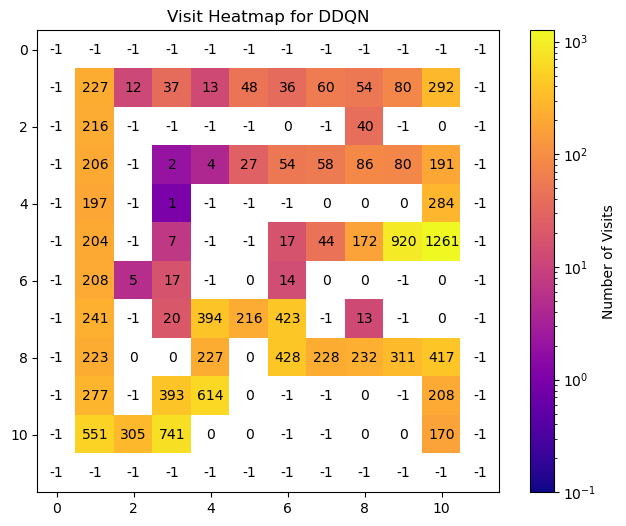

In [186]:
# Assuming maze_size_x and maze_size_y are the dimensions of your maze
# convert to dictionary
episode_path_dict = {}
for episode, position in episode_path_history:
    if episode in episode_path_dict:
        episode_path_dict[episode].append(position)
    else:
        episode_path_dict[episode] = [position]

maze = env.maze

visit_counts = np.zeros((maze.shape[0], maze.shape[1]), dtype=int)

visit_counts[env.maze == 1] = -1
print(visit_counts)


for episode, path in episode_path_dict.items():
    for position in path:
        visit_counts[position] += 1

from math import nan
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, LogNorm


def plot_visit_heatmap(visit_counts, title="Visit Heatmap"):
    # Transpose visit_counts to match the expected orientation
    visit_counts_transposed = visit_counts.T  # Transpose the matrix

    # Filter out the wall cells by setting their count to NaN for visualization
    filtered_counts = np.where(
        visit_counts_transposed == -1, np.nan, visit_counts_transposed
    )

    # Define a continuous colormap (you can choose any colormap you like)
    cmap = plt.cm.plasma
    cmap.set_bad("white")  # Use gray for NaN (walls)
    plt.figure(figsize=(8, 6))
    # Use LogNorm for logarithmic normalization; set vmin to a small value > 0 to handle cells with 0 visits
    plt.imshow(
        filtered_counts,
        cmap=cmap,
        norm=LogNorm(vmin=0.1, vmax=np.nanmax(filtered_counts)),
        interpolation="nearest",
    )
    # add the nr of visits to the cells
    for i in range(visit_counts_transposed.shape[0]):
        for j in range(visit_counts_transposed.shape[1]):
            if visit_counts_transposed[i, j] != -1 or visit_counts_transposed[i, j] != nan:
                plt.text(j, i, visit_counts_transposed[i, j], ha="center", va="center")
                
    plt.colorbar(label="Number of Visits")
    plt.title(title)
    plt.show()


plot_visit_heatmap(visit_counts, title="Visit Heatmap for DDQN")

In [190]:
!pip install plotly --break

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 16.9 MB/s eta 0:00:0000:0100:01


[2520, 743, 83, 81, 1442, 51, 73, 103, 72, 46, 56, 52, 38, 93, 62, 134, 54, 49, 59, 70, 80, 84, 54, 39, 68, 45, 47, 66, 43, 37, 41, 43, 50, 41, 37, 50, 39, 45, 66, 51, 43, 47, 37, 40, 49, 35, 46, 33, 42, 41, 39, 41, 39, 34, 42, 38, 44, 38, 39, 33, 39, 35, 48, 46, 41, 39, 41, 41, 37, 41, 41, 37, 43, 40, 37, 35, 43, 44, 37, 33, 45, 33, 36, 37, 42, 46, 41, 43, 33, 33, 45, 33, 37, 37, 35, 39, 40, 36, 36, 38, 33, 41, 33, 38, 45, 37, 35, 35, 35, 40, 40, 36, 33, 41, 79, 37, 37, 35, 35, 35, 34, 37, 33, 33, 39, 39, 33, 36, 35, 39, 34, 37, 49, 36, 35, 35, 35, 33, 41, 38, 33, 35, 36, 35, 35, 33, 34, 37, 33, 35, 35, 37, 33, 36, 33, 33, 33, 34, 33, 33, 33, 36, 33, 33, 35, 37, 39, 35, 36, 37]


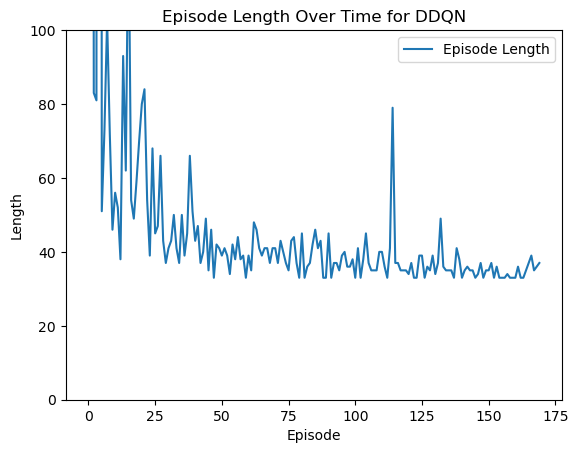

In [187]:
def plot_episode_lengths(episode_lengths, title="Episode Length Over Time"):
    plt.plot(episode_lengths, label="Episode Length")
    plt.xlabel("Episode")
    plt.ylabel("Length")
    plt.title(title)
    plt.legend()
    # y limit to avoid showing outliers
    plt.ylim(0, 100)
    plt.show()

print(step_history)

plot_episode_lengths(step_history, title="Episode Length Over Time for DDQN")

## test

In [172]:
# try it out
# load model
env = RCMazeEnv()
state = env.reset()

REPLAY_MEMORY_CAPACITY = 2000000
POSSIBLE_ACTIONS = env.possible_actions

# create DQN agent
test_agent = DQNAgent(replayCapacity=REPLAY_MEMORY_CAPACITY, input_shape=state.shape, output_shape=len(POSSIBLE_ACTIONS))

test_agent.policy_model = load_model('../models/DDQN_RCmaze_v3.h5')


done = False

rewards = []
solution_path = []
test_steps = 0

while not done:
    env.render(delay=100, framerate=10)
    qValues = test_agent.policy_network_predict(np.array([state]))
    action = np.argmax(qValues[0])
    state, reward, done = env.step(action)
    rewards.append(reward)
    test_steps += 1
    print(env.car_position)
    solution_path.append(env.car_position)
    env.render()
    if done:
        print('done in ', len(rewards), 'steps')
        break
env.close()
print(sum(rewards))
print('steps: ', test_steps)
env.close_pygame()

2024-04-09 17:34:01.033630: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_189/kernel/Assign' id:15359 op device:{requested: '', assigned: ''} def:{{{node dense_189/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_189/kernel, dense_189/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-04-09 17:34:01.523252: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_137_6/kernel/Assign' id:15543 op device:{requested: '', assigned: ''} def:{{{node dense_137_6/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_137_6/kernel, dense_137_6/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. 

(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(1, 10)
(1, 10)
(2, 10)
(3, 10)
(3, 10)
(3, 9)
(3, 9)
(4, 9)
(4, 9)
(4, 8)
(4, 7)
(4, 7)
(5, 7)
(6, 7)
(6, 7)
(6, 8)
(6, 8)
(7, 8)
(8, 8)
(9, 8)
(10, 8)
(10, 8)
(10, 9)
(10, 10)
done in  33 steps
1269.7326524824198
steps:  33


In [168]:
test_agent.policy_model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_136 (Dense)           (None, 32)                224       
                                                                 
 dense_137 (Dense)           (None, 64)                2112      
                                                                 
 dense_138 (Dense)           (None, 32)                2080      
                                                                 
 dense_139 (Dense)           (None, 3)                 99        
                                                                 
Total params: 4515 (17.64 KB)
Trainable params: 4515 (17.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [169]:
# test_agent.policy_model.save('./main_web_app/models/DDQN_RCmaze_v2.h5')# 

[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 10), (2, 10), (3, 10), (3, 10), (3, 9), (3, 9), (4, 9), (4, 9), (4, 8), (4, 7), (4, 7), (5, 7), (6, 7), (6, 7), (6, 8), (6, 8), (7, 8), (8, 8), (9, 8), (10, 8), (10, 8), (10, 9), (10, 10)]


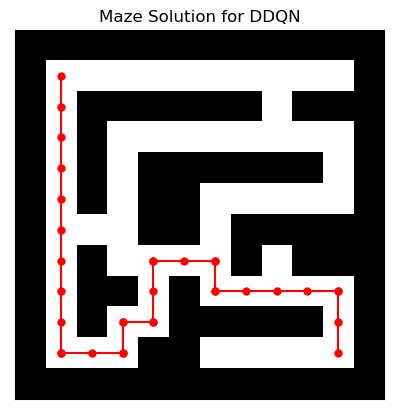

In [188]:
def plot_maze_solution(maze, path, title="Maze Solution"):
    plt.imshow(maze, cmap="binary")
    x, y = zip(*path)  # Assuming path is a list of (x, y) tuples
    plt.plot(
        x, y, marker="o", color="r", markersize=5
    ) 
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks
    plt.title(title)
    plt.show()


# Example usage
# get the path
path = solution_path
print(path)
plot_maze_solution(env.maze, path, title="Maze Solution for DDQN")

# PPO

In [ ]:
class PPOAgent:
    def __init__(self, action_dim, observation_dim, env=RCMazeEnv()):
        self.action_dim = action_dim
        self.observation_dim = observation_dim
        self.policy_network = self.build_policy_network()
        self.value_network = self.build_value_network()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.clip_epsilon = 0.2
        self.env = env

    def build_policy_network(self):
        # Create a policy network appropriate for your custom environment
        policy_network = tf.keras.Sequential(
            [
                tf.keras.layers.Input(
                    shape=(6,)
                ),  # Adjust the input shape to (None, 6)
                tf.keras.layers.Dense(64, activation="relu"),
                tf.keras.layers.Dense(self.action_dim, activation="softmax"),
            ]
        )
        return policy_network

    def build_value_network(self):
        # Create a value network appropriate for your custom environment
        value_network = tf.keras.Sequential(
            [
                tf.keras.layers.Input(
                    shape=(6,)
                ),  # Adjust the input shape to (None, 6)
                tf.keras.layers.Dense(64, activation="relu"),
                tf.keras.layers.Dense(self.action_dim, activation="linear"),
            ]
        )
        return value_network

    def compute_loss(self, observations, actions, advantages, old_probabilities):
        # Compute the surrogate loss for PPO
        new_probabilities = self.policy_network(observations)
        action_masks = tf.one_hot(actions, self.action_dim, dtype=tf.float32)
        new_action_probabilities = tf.reduce_sum(
            action_masks * new_probabilities, axis=1
        )
        old_action_probabilities = tf.reduce_sum(
            action_masks * old_probabilities, axis=1
        )

        ratio = new_action_probabilities / (old_action_probabilities + 1e-10)
        surrogate_objective = tf.minimum(
            ratio * advantages,
            tf.clip_by_value(ratio, 1 - self.clip_epsilon, 1 + self.clip_epsilon)
            * advantages,
        )
        loss = -tf.reduce_mean(surrogate_objective)
        return loss

    def train_step(self, observations, actions, advantages, old_probabilities):
        with tf.GradientTape() as tape:
            loss = self.compute_loss(
                observations, actions, advantages, old_probabilities
            )
        grads = tape.gradient(loss, self.policy_network.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.policy_network.trainable_variables)
        )
        return loss

    def train(self, num_episodes, max_steps_per_episode):
        for episode in range(num_episodes):
            observations = []
            actions = []
            rewards = []
            old_probabilities = []

            observation = self.env.reset()
            for step in range(max_steps_per_episode):
                flattened_observation = np.array([])
                for element in observation:
                    if isinstance(element, tuple):
                        flattened_observation = np.concatenate(
                            (flattened_observation, np.array(element))
                        )
                    else:
                        flattened_observation = np.concatenate(
                            (flattened_observation, np.array([element]))
                        )

                print("flattened_observation:", flattened_observation)
                action_probabilities = self.policy_network.predict(
                    np.expand_dims(flattened_observation, axis=0)
                )
                action = np.random.choice(
                    self.action_dim, p=action_probabilities.ravel()
                )
                next_observation, reward, done = self.env.step(action)
                observation = next_observation  # Update observation for the next step

                observations.append(observation)
                actions.append(action)
                rewards.append(reward)
                old_probabilities.append(action_probabilities.ravel())

                observation = next_observation

                if done:
                    break

            discounted_rewards = self.compute_discounted_rewards(rewards)

            print("discounted_rewards:", discounted_rewards)
            advantages = self.compute_advantages(discounted_rewards, observations)

            observations = np.vstack(observations)
            actions = np.array(actions)
            old_probabilities = np.vstack(old_probabilities)

            for _ in range(10):  # PPO optimization steps
                loss = self.train_step(
                    observations, actions, advantages, old_probabilities
                )

            print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {sum(rewards)}")

    def compute_discounted_rewards(self, rewards, gamma=0.99):
        discounted_rewards = np.zeros_like(rewards, dtype=np.float32)
        running_add = 0
        for t in reversed(range(len(rewards))):
            running_add = running_add * gamma + rewards[t]
            discounted_rewards[t] = running_add
        mean = np.mean(discounted_rewards)
        std = np.std(discounted_rewards)
        discounted_rewards = (discounted_rewards - mean) / (std + 1e-8)
        return discounted_rewards

    def compute_advantages(self, discounted_rewards, observations):
        try:
            values = self.value_network.predict(observations)
            print("values:", values)
            advantages = discounted_rewards - values.ravel()
            print("advantages:", advantages)
            return advantages
        except:
            return discounted_rewards


def state_to_tuple(state):

    # ((0, 0), 'N', {'front': 1, 'left': 0, 'right': 0})
    # if like this convert to ((0, 0), 'N', (1, 0, 0))
    if not isinstance(state[2], dict):
        # print(state)
        # print(state[2])
        # take state[2] and make it from this (1, 0, 0) to this {'front': 1, 'left': 0, 'right': 0}
        newState = {"front": state[2][0], "left": state[2][1], "right": state[2][2]}
        # print(newState)
        # create a new state with the [2] being the new dictionary
        state = (state[0], state[1], newState)

    # Convert the state dictionary to a hashable tuple
    # Adjust this based on the specific format of your state
    position, orientation, sensor_readings = state
    sensor_readings_tuple = tuple(sensor_readings.values())
    return (position, orientation, sensor_readings_tuple)

In [ ]:
env = RCMazeEnv()  # Create your custom environment

observation_dim = env.reset().shape[
    0
]  # Adjust this based on your custom environment's state space
action_dim = 3  # Adjust this based on your custom environment's action space
ppo_agent = PPOAgent(action_dim, observation_dim, env)

ppo_agent.train(num_episodes=100, max_steps_per_episode=200)

In [ ]:
observation = env.reset()
total_reward = 0
while True:
    action_probabilities = agent.policy_network.predict(
        np.expand_dims(observation, axis=0)
    )
    action = np.random.choice(agent.action_dim, p=action_probabilities.ravel())
    observation, reward, done, _ = env.step(action)
    total_reward += reward
    if done:
        break
print(f"Total Reward: {total_reward}")